In [1]:
# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

# in order to use custom modules in parent path
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from mfilter.implementations.simulate import SimulateSignal
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
#from mfilter.hypothesistest.probabilities import HypothesisTesting
%matplotlib inline
plt.style.use('seaborn')

[20.0, 40.0, 60.0]


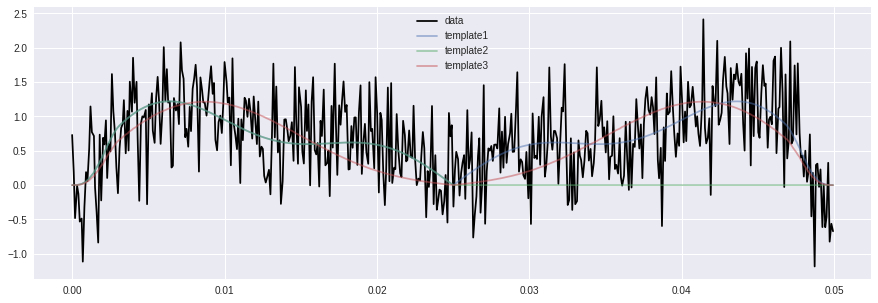

In [89]:
def gen_data(n_samples, underlying_delta=50, min_freq=None):
    min_freq = 1 / (n_samples * underlying_delta) if min_freq is None else min_freq
    freq = [min_freq, min_freq * 2, min_freq * 3]
    weights=[1, 0.3, 0.3]
    config="slight"
    noise_level=0.5
    simulated = SimulateSignal(n_samples, freq, weights=weights, noise_level=noise_level,
                               dwindow="tukey", underlying_delta=underlying_delta)

    # get the times
    times = simulated.get_times(configuration=config)

    # next generate 2 templates of different number of peaks and position of start
    pos_start_t1 = 0
    pos_start_t2 = 0
    temp1 = simulated.get_data(pos_start_peaks=pos_start_t1, n_peaks=1, with_noise=False,
                              configuration=config)
    temp1 = abs(temp1)
    temp2 = simulated.get_data(pos_start_peaks=pos_start_t2, n_peaks=0.5, with_noise=False,
                              configuration=config)
    temp2 = abs(temp2)
    # and generate the noise
    noise = simulated.get_noise(None)

    # finally we create another template with different form
    freq2 = [min_freq, min_freq * 2]
    weights2=[1, 0.4]
    simulated2 = SimulateSignal(n_samples, freq2, weights=weights2,
                               dwindow="tukey", underlying_delta=underlying_delta)
    pos_start_t3 = pos_start_t1
    temp3 = simulated2.get_data(pos_start_peaks=pos_start_t3, n_peaks=1, with_noise=False,
                              configuration=config)
    temp3 = abs(temp3)
    # and create the data
    data = noise + temp1
    # set all as TimeSeries, in the future SimulateData class should return timeseries by his own
    times = TimesSamples(initial_array=times)
    temp1 = TimeSeries(temp1, times=times)
    temp2 = TimeSeries(temp2, times=times)
    temp3 = TimeSeries(temp3, times=times)
    data = TimeSeries(data, times=times)
    noise = TimeSeries(noise, times=times)

    return times, data, noise, temp1, temp2, temp3, freq

times, data, noise, temp1, temp2, temp3, freq = gen_data(500, underlying_delta=0.0001)
print(freq)
# put all in a plot
plt.figure(figsize=(15, 5))
plt.plot(times, data, 'k', label="data")
plt.plot(times, temp1, label="template1", alpha=0.5)
plt.plot(times, temp2, label="template2", alpha=0.5)
plt.plot(times, temp3, label="template3", alpha=0.5)
plt.legend()

In [103]:
# first define the sampling grid
samples_per_peak = 10


freqs = FrequencySamples(input_time=times,
                        minimum_frequency=-1001,
                        maximum_frequency=1001,
                        samples_per_peak=samples_per_peak)

F = Dictionary(times, freqs)
reg = RidgeRegression(alpha=0.0000000000001, phi=F)
# reg = ElasticNetRegression(alpha=0.01, l1_ratio=0.7, phi=F)
# reg = LassoRegression(alpha=0.001, phi=F)
print(F.shape(splited=True))

(1000, 1000)


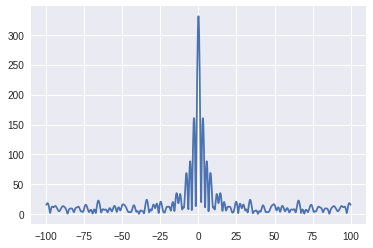

In [60]:
plt.plot(freqs, np.abs(beta))

1.0


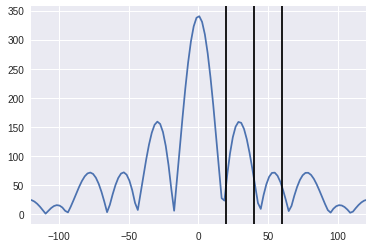

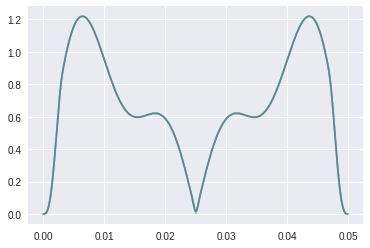

In [105]:
m = np.copy(F.matrix)
beta = np.dot(F.matrix, temp1.value)
plt.figure()
plt.plot(freqs, abs(beta))
plt.axvline(freq[0], color="k")
plt.axvline(freq[1], color="k")
plt.axvline(freq[2], color="k")
plt.xlim([-2*freq[2], 2*freq[2]])

bb = np.hstack((beta.real, beta.imag))
reg._reg.fit(np.vstack((m.real, m.imag)), bb)
coefs = reg._reg.coef_
print(reg._reg.score(np.vstack((m.real, m.imag)), bb))

def cast_into_times(coefs):
    n_times = int(len(coefs)/2)
    data = np.zeros(n_times)
    for i in range(n_times):
        data[i] = coefs[i] + coefs[i + n_times]
    return data

back_data = cast_into_times(coefs)
plt.figure()
plt.plot(times, coefs)
plt.plot(times, temp1, alpha=0.5)

In [50]:
mm = np.vstack((m.real, m.imag))
bb = np.hstack((beta.real, beta.imag))
print(mm.shape, bb.shape)

(1200, 500) (1200,)
